Orijinal Sınıf Dağılımı:
 Label
0    6871
1    1407
Name: count, dtype: int64

Dengelenmiş Sınıf Dağılımı:
 Label
0    6871
1    6871
Name: count, dtype: int64

Scikit-learn Balanced Model
Training Time: 0.011080265045166016
Test Time: 0.0003578662872314453
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.29      0.39      1375
           1       0.54      0.82      0.65      1374

    accuracy                           0.55      2749
   macro avg       0.58      0.55      0.52      2749
weighted avg       0.58      0.55      0.52      2749


Custom Model Class Weight: 0.9998180825905039
Step 0: Cost 0.6936476169115219
Step 1000: Cost 0.68407961243899
Step 2000: Cost 0.6839444035046832
Step 3000: Cost 0.6839060178101494
Step 4000: Cost 0.6838875652803411
Step 5000: Cost 0.683877153635495
Step 6000: Cost 0.6838710597006343
Step 7000: Cost 0.6838674682583022
Step 8000: Cost 0.6838653499912724
Step 9000: Cost 0.6838641010149792


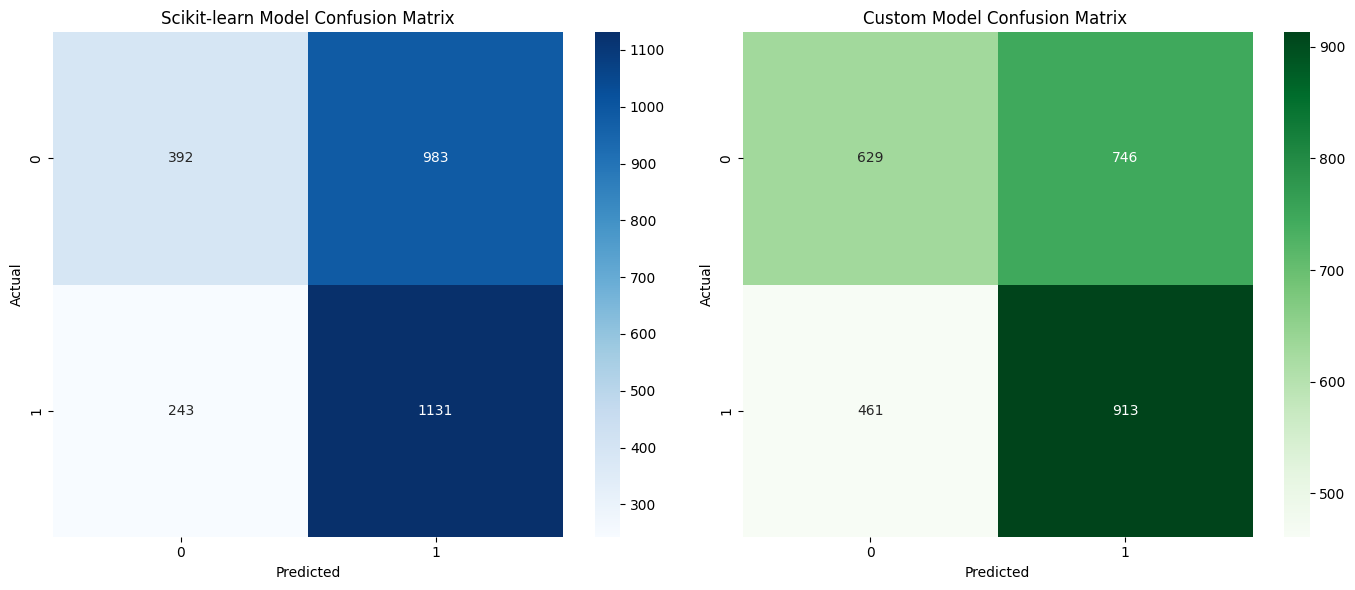

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("Heli_crashes.csv")

print("Orijinal Sınıf Dağılımı:\n", df['Label'].value_counts())

df_majority = df[df['Label'] == 0]
df_minority = df[df['Label'] == 1]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

print("\nDengelenmiş Sınıf Dağılımı:\n", df_balanced['Label'].value_counts())

X = df_balanced.drop(columns=['Label'])
y = df_balanced['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start_time = time.time()
sk_model_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
sk_model_balanced.fit(X_train_scaled, y_train)
sklearn_train_time_bal = time.time() - start_time

start_time = time.time()
y_pred_sk_bal = sk_model_balanced.predict(X_test_scaled)
sklearn_test_time_bal = time.time() - start_time

sklearn_cm_bal = confusion_matrix(y_test, y_pred_sk_bal)
sklearn_accuracy_bal = accuracy_score(y_test, y_pred_sk_bal)

print("\nScikit-learn Balanced Model")
print("Training Time:", sklearn_train_time_bal)
print("Test Time:", sklearn_test_time_bal)
print("Classification Report:\n", classification_report(y_test, y_pred_sk_bal))

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def compute_weighted_cost(X, y, W, pos_weight):
    Z = np.dot(X, W)
    y_pred = sigmoid(Z)
    cost = -np.mean(pos_weight * y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
    return cost

def weighted_gradient_descent(X, y, W, pos_weight, learning_rate=0.01, n_steps=10000, print_cost=False):
    m = X.shape[0]
    for i in range(n_steps):
        Z = np.dot(X, W)
        y_pred = sigmoid(Z)
        gradient = np.dot(X.T, (pos_weight * y * (y_pred - 1) + (1 - y) * y_pred)) / m
        W -= learning_rate * gradient
        if print_cost and i % 1000 == 0:
            cost = compute_weighted_cost(X, y, W, pos_weight)
            print(f"Step {i}: Cost {cost}")
    return W

X_train_np = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_np = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]
y_train_np = y_train.values.reshape(-1, 1)
y_test_np = y_test.values.reshape(-1, 1)

neg_count = np.sum(y_train_np == 0)
pos_count = np.sum(y_train_np == 1)
pos_weight = neg_count / pos_count
print(f"\nCustom Model Class Weight: {pos_weight}")

np.random.seed(42)
weights_initial = np.random.randn(X_train_np.shape[1], 1) * 0.01

start_time = time.time()
weights_final_bal = weighted_gradient_descent(
    X_train_np, y_train_np, weights_initial, 
    pos_weight=pos_weight, learning_rate=0.01, n_steps=10000, print_cost=True
)
custom_train_time_bal = time.time() - start_time

start_time = time.time()
y_pred_probs = sigmoid(np.dot(X_test_np, weights_final_bal))
custom_test_time_bal = time.time() - start_time

fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_probs)
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"\nOptimal Threshold: {optimal_threshold}")

y_preds_bal = (y_pred_probs > optimal_threshold).astype(int)

custom_cm_bal = confusion_matrix(y_test_np, y_preds_bal)
custom_accuracy_bal = accuracy_score(y_test_np, y_preds_bal)

print("\nCustom Model")
print("Training Time:", custom_train_time_bal)
print("Test Time:", custom_test_time_bal)
print("Classification Report:\n", classification_report(y_test_np, y_preds_bal))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(sklearn_cm_bal, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Scikit-learn Model Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(custom_cm_bal, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Custom Model Confusion Matrix ')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()